In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk # just for tokenization
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import random
import gradio 
import string

random.seed(42)

c:\Users\shivs\anaconda3\envs\chess-engine\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin
wv_from_bin = load_embedding_model()
# wv_from_bin = load_embedding_model()

Loaded vocab size 3000000


In [4]:
labelled_raw_df = pd.read_csv("MultiLabel.csv")
print(labelled_raw_df.head())

           artist    genre                  title                    album  \
0         Nirvana     Rock  You Know You’re Right                  Nirvana   
1   Damian Marley   Reggae             Here We Go               Stony Hill   
2  The Mission UK     Rock                   Jade  Another Fall from Grace   
3            UB40   Reggae       Food For Thought              Signing Off   
4     Johnny Cash  Country   I’ve Been Everywhere   American II: Unchained   

     year                                             lyrics  \
0  2002.0  I will never bother you\r\nI will never promis...   
1  2017.0  Here we go\r\nMy big ego is gonna get me in tr...   
2  2016.0  She came as Lolita dressed as Venus\r\nAnd ado...   
3  1980.0  Ivory Madonna, dying in the dust\r\nWaiting fo...   
4  1996.0  I was totin' my pack along the dusty Winnemucc...   

                                       labels  
0                           Calmness, Sadness  
1                              Power, Tension  
2 

In [6]:
raw_df = pd.read_csv("../../Spotify Song Dataset.csv/million_songs.csv")
raw_df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [7]:
def tokenize(lyric: str) -> list[str]:
    # lowercase the text, remove stop words, punctuation and keep only the words
    tokens = nltk.tokenize.word_tokenize(lyric.lower())
    stop_words = stopwords.words("english") + list(string.punctuation)
    lemmatizer = WordNetLemmatizer()
    alpha_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]

    return alpha_tokens

In [8]:
def vectorise(lyrics: str) -> np.ndarray:
    tokens = tokenize(lyrics)
    lyric_vector = np.zeros(300)
    for token in tokens:
        try:
            lyric_vector += wv_from_bin.get_vector(token.lower())
        except:
            continue
    return lyric_vector / np.linalg.norm(lyric_vector)

In [10]:
# go through each lyrics, tokenize it, vectorize each word, then combine all of them into single average vector and store it in the list
lyrics = raw_df["text"]
lyrics_embeddings = []
unsupported_tokens = set()
label_embedding_map = {} # dict{str: np.array([])}
for lyric in tqdm(lyrics):
    lyric_vector = np.zeros(300)
    for token in tokenize(lyric):
        try:
            lyric_vector += wv_from_bin.get_vector(token.lower())
        except KeyError as e:
            # if the word is not present in the glove then key error is raised, so handle the exception and move on
            unsupported_tokens.add(token)
            continue
    lyrics_embeddings.append(lyric_vector)


lyrics_embeddings = np.stack(lyrics_embeddings)
scaled_lyrics_embeddings = lyrics_embeddings / np.linalg.norm(lyrics_embeddings, axis=1, keepdims=True)

  0%|          | 0/57650 [00:00<?, ?it/s]

100%|██████████| 57650/57650 [02:18<00:00, 416.72it/s]


In [17]:
def distance(metric: str, embedding_matrix: np.ndarray, test_vector: np.ndarray) -> np.ndarray:
    if metric == "cosine":
            
        dot_product = np.dot(embedding_matrix, test_vector)

        # Compute magnitudes
        embedding_magnitudes = np.linalg.norm(embedding_matrix, axis=1)
        test_vector_magnitude = np.linalg.norm(test_vector)

        # Compute cosine similarity
        cosine_similarity = dot_product / (embedding_magnitudes * test_vector_magnitude)
        return cosine_similarity
    elif metric == "euclidean":
        distances = np.linalg.norm(scaled_lyrics_embeddings - test_vector, axis=1)
        return distances
    else:
        raise Exception(f"Invalid parameter value {metric}")

In [22]:
def cosine_distance(X, centroids):
    # Compute cosine similarity between each data point and each centroid
    dot_product = np.dot(X, centroids.T)
    norms_X = np.linalg.norm(X, axis=1)[:, np.newaxis]
    norms_centroids = np.linalg.norm(centroids, axis=1)
    cosine_similarities = dot_product / (norms_X * norms_centroids)
    
    # Convert cosine similarities to cosine distances
    cosine_distances = 1 - cosine_similarities
    
    return cosine_distances

In [28]:
embeddings = np.load("./embeddings/emotions_embeddings_v1.npy")
labels = np.array(
            [
                "Calmness",
                "Sadness",
                "Power",
                "Tension",
                "Amazement",
                "Solemnity",
                "Tenderness",
                "Joyful activation",
                "Nostalgia",
            ])

In [30]:
embeddings.shape, scaled_lyrics_embeddings.shape

((9, 300), (57650, 300))

In [98]:
embeddings[0] == embeddings[1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [102]:
import numpy as np

def kmeans(X, centroids, max_iterations=100):
    print(X.shape)
    for _ in tqdm(range(max_iterations)):
        # Assign each data point to the nearest centroid
        distances = cosine_distance(X, centroids)  # Calculate distances
        labels = np.argmin(distances, axis=1)  # Assign labels
       
        # Update centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(centroids.shape[0])])
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    
    return labels, centroids



In [106]:

initial_centroids = scaled_lyrics_embeddings[np.random.choice(scaled_lyrics_embeddings.shape[0], 9, replace=False)]
# Perform K-means clustering
labels, centroids = kmeans(scaled_lyrics_embeddings,initial_centroids, max_iterations=100)

print("Cluster centroids:", centroids)
print("Cluster labels:", labels)


(57650, 300)


 94%|█████████▍| 94/100 [00:14<00:00,  6.40it/s]

Cluster centroids: [[ 0.05454307  0.04657343  0.02159681 ... -0.05083053  0.02565279
  -0.02165592]
 [ 0.02821704  0.03657216  0.02831213 ... -0.08274256 -0.00347676
   0.0122498 ]
 [ 0.05151636  0.01825972  0.02488937 ... -0.06611451  0.00817355
  -0.01006545]
 ...
 [ 0.06970265  0.04425886  0.03492013 ... -0.08028398  0.00151023
   0.01954784]
 [ 0.05347388  0.05370094  0.01628631 ... -0.04526272  0.03518553
  -0.00982266]
 [ 0.04824656  0.02872261  0.02536814 ... -0.06136277  0.02768604
  -0.02785426]]
Cluster labels: [8 7 8 ... 0 0 8]


In [110]:
centeroids.shape

(7, 300)

In [107]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

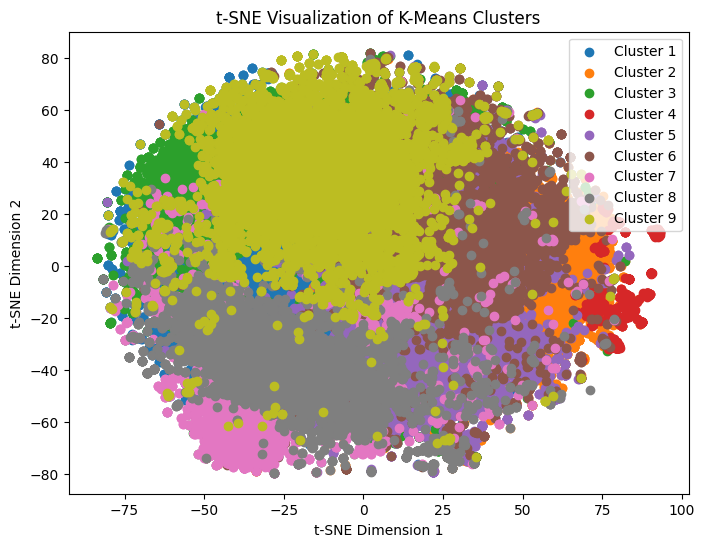

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Get cluster labels
cluster_labels = labels
k = 9
# Apply t-SNE to reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
word_embeddings_tsne = tsne.fit_transform(scaled_lyrics_embeddings)

# Plot t-SNE visualization with cluster labels
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(word_embeddings_tsne[cluster_labels == i, 0], 
                word_embeddings_tsne[cluster_labels == i, 1], 
                label=f'Cluster {i+1}')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of K-Means Clusters')
plt.legend()
plt.show()

In [173]:
song = """
I walk a lonely road
The only one that I have ever known
Don't know where it goes
But it's only me, and I walk alone
I walk this empty street
On the boulevard of broken dreams
Where the city sleeps
And I'm the only one, and I walk alone
I walk alone, I walk alone
I walk alone, and I walk a
My shadow's the only one that walks beside me
My shallow heart's the only thing that's beating
Sometimes I wish someone out there will find me
'Til then I walk alone
Ah ah ah ah ah
Ah ah ah
I'm walking down the line
That divides me somewhere in my mind
On the border line of the edge
And where I walk alone
Read between the lines
What's fucked up and every thing's all right
Check my vital signs to know I'm still alive
And I walk alone
I walk alone, I walk alone
I walk alone and I walk a
My shadow's the only one that walks beside me
My shallow heart's the only thing that's beating
Sometimes I wish someone out there will find me
'Til then I walk alone
Ah ah ah ah ah
Ah ah
I walk alone, and I walk a
I walk this empty street
On the boulevard of broken dreams
Where the city sleeps
And I'm the only one, and I walk a
My shadow's the only one that walks beside me
My shallow heart's the only thing that's beating
Sometimes I wish someone out there will find me
'Til then I walk alone
"""

In [227]:
def predict(lyrics: str) -> str:
    song_vector = vectorise(lyrics)[None,:]
    return labels[np.argmin(cosine_distance(X=song_vector ,centroids=centroids))]

In [228]:
labels = {
            0: ["Calmness", "Sadness", "Nostalgia"],
            1: ["Joyful activation", "Power", "Tension"],
            2: ["Amazement", "Solemnity", "Tenderness"],
            3: ["Joyful activation", "Power", "Tension"],
            4: ["Nostalgia", "Calmness", "Sadness"],
            5: ["Amazement", "Solemnity", "Tenderness"],
            6: ["Calmness", "Sadness", "Amazement"],
            7: ["Calmness", "Sadness"],
            8: ["Calmness", "Nostalgia"],
        }


In [229]:
predict(song)

['Calmness', 'Sadness', 'Nostalgia']

In [177]:
np.save("kmeans_centeroids_v1.npy", centroids)

In [178]:
centeroids.shape

(7, 300)

In [217]:
d = {}
for i, l in enumerate(labels[np.argsort(cosine_distance(centroids, embeddings), axis=1)[:, :3]]):
    d[i] = list(l)

In [218]:
d

{0: ['Calmness', 'Sadness', 'Nostalgia'],
 1: ['Joyful activation', 'Power', 'Tension'],
 2: ['Amazement', 'Solemnity', 'Tenderness'],
 3: ['Joyful activation', 'Power', 'Tension'],
 4: ['Nostalgia', 'Calmness', 'Sadness'],
 5: ['Amazement', 'Solemnity', 'Tenderness'],
 6: ['Calmness', 'Sadness', 'Amazement'],
 7: ['Calmness', 'Sadness', 'Nostalgia'],
 8: ['Calmness', 'Sadness', 'Nostalgia']}

In [219]:
dis = cosine_distance(centroids, embeddings)

In [221]:
np.argsort(cosine_distance(centroids, embeddings))

array([[0, 1, 8, 4, 5, 6, 2, 3, 7],
       [7, 2, 3, 4, 5, 6, 8, 0, 1],
       [4, 5, 6, 0, 1, 8, 7, 2, 3],
       [7, 2, 3, 4, 5, 6, 0, 1, 8],
       [8, 0, 1, 4, 5, 6, 7, 2, 3],
       [4, 5, 6, 8, 0, 1, 7, 2, 3],
       [0, 1, 4, 5, 6, 8, 2, 3, 7],
       [0, 1, 8, 4, 5, 6, 7, 2, 3],
       [0, 1, 8, 4, 5, 6, 2, 3, 7]], dtype=int64)

In [199]:
d

{0: ['Calmness', 'Sadness'],
 1: ['Joyful activation', 'Power'],
 2: ['Amazement', 'Solemnity'],
 3: ['Joyful activation', 'Power'],
 4: ['Nostalgia', 'Calmness'],
 5: ['Amazement', 'Solemnity'],
 6: ['Calmness', 'Sadness'],
 7: ['Calmness', 'Sadness'],
 8: ['Calmness', 'Sadness']}

In [193]:
cosine_distance(centroids, embeddings)[:, :2]

array([[0.03059446, 0.03059446],
       [0.03834659, 0.03834659],
       [0.03909744, 0.03909744],
       [0.37645089, 0.37645089],
       [0.0127083 , 0.0127083 ],
       [0.00829108, 0.00829108],
       [0.06959563, 0.06959563],
       [0.05214194, 0.05214194],
       [0.03519053, 0.03519053]])

In [ ]:
{0: ['Calmness', 'Sadness'], 1:['Joyful activation', 'Power'], 2:labels[4], 3:labels[]}

In [189]:
raw_df.loc[np.argmin(cosine_distance(centroids, scaled_lyrics_embeddings), axis=1)]

,artist,song,link,text
54243,Ufo,Flying,/u/ufo/flying_20141854.html,[disputed lyrics in brackets] \r\nHave you ev...
45718,Nicki Minaj,Barbie World Intro,/n/nicki+minaj/barbie+world+intro_20873938.html,[Chorus:] \r\nI wanna get to know you \r\nI ...
41931,LL Cool J,I Need Love,/l/ll+cool+j/i+need+love_20081043.html,When I'm alone in my room \r\nSometimes I sta...
20365,Utada Hikaru,Final Distance,/u/utada+hikaru/final+distance_10162343.html,Ki ni naru noni kikenai \r\nOyogitsukarete ki...
5072,Eminem,Crack A Bottle,/e/eminem/crack+a+bottle_20775965.html,Ladies and gentlemen \r\nThe moment you've al...
54879,Vanilla Ice,I Go Down,/v/vanilla+ice/i+go+down_20143665.html,[Verse 1] \r\nI Remember way back when \r\nL...
36722,Indiana Bible College,Because Of Love,/i/indiana+bible+college/because+of+love_20997...,[Verse:] \r\nBecause of love He left His thro...
42933,Marillion,This Strange Engine,/m/marillion/this+strange+engine_20088964.html,There was a boy who came into this world \r\n...
4572,Dream Theater,Space-Dye Vest,/d/dream+theater/space+dye+vest_20043326.html,Falling through pages of Martens on angels \r...
